In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from PIL import Image
import time

In [2]:
print("TensorFlow version:", tf.__version__)
print("Is GPU available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.19.0
Is GPU available: []


In [3]:
from tensorflow.python.platform import build_info as tf_build_info
print("CUDA support:", tf_build_info.build_info.get("cuda_version", "Not built with CUDA"))
print("cuDNN support:", tf_build_info.build_info.get("cudnn_version", "Not built with cuDNN"))

CUDA support: Not built with CUDA
cuDNN support: Not built with cuDNN


- Tensorflow is compiled with CUDA. So it has GPU support and CNN training would be fast.

In [5]:
data_path = os.getcwd().replace("code", "data")

In [6]:
# Verify the dataset path and structure
print("Dataset path:", data_path)
print("Contents of dataset_path:", os.listdir(data_path))

Dataset path: c:\Users\Marc Jay\Ironhack\CV-Project
Contents of dataset_path: ['.git', 'main.ipynb', 'main_final.ipynb', 'README.md', 'test', 'train', 'val']


In [8]:
train_dir = os.path.join(data_path, "train")
test_dir = os.path.join(data_path, "test")
validation_dir = os.path.join(data_path, "val")

In [9]:
# Verify train, test and validation directories
print("Train directory contents:", os.listdir(train_dir))
print("Test directory contents:", os.listdir(test_dir))
print("Validation directory contents:", os.listdir(validation_dir))

Train directory contents: ['fractured', 'not fractured']
Test directory contents: ['fractured', 'not fractured']
Validation directory contents: ['fractured', 'not fractured']


In [10]:
def rename_files_recursive(folder_path):
    """
    Recursively renames files in the given folder and its subfolders,
    replacing spaces with underscores in filenames.
    """
    for dirpath, _, filenames in os.walk(folder_path):
        for filename in filenames:
            if ' ' in filename:
                old_path = os.path.join(dirpath, filename)
                new_filename = filename.replace(' ', '_')
                new_path = os.path.join(dirpath, new_filename)
                os.rename(old_path, new_path)
                print(f'Renamed: "{old_path}" → "{new_path}"')

rename_files_recursive(os.path.join(train_dir, "fractured"))
rename_files_recursive(os.path.join(train_dir, "not fractured"))
rename_files_recursive(os.path.join(test_dir, "fractured"))
rename_files_recursive(os.path.join(test_dir, "not fractured"))
rename_files_recursive(os.path.join(validation_dir, "fractured"))
rename_files_recursive(os.path.join(validation_dir, "not fractured"))

Renamed: "c:\Users\Marc Jay\Ironhack\CV-Project\train\not fractured\1 (1).jpg" → "c:\Users\Marc Jay\Ironhack\CV-Project\train\not fractured\1_(1).jpg"
Renamed: "c:\Users\Marc Jay\Ironhack\CV-Project\train\not fractured\1 (2).jpg" → "c:\Users\Marc Jay\Ironhack\CV-Project\train\not fractured\1_(2).jpg"
Renamed: "c:\Users\Marc Jay\Ironhack\CV-Project\train\not fractured\1-rotated1 (1).jpg" → "c:\Users\Marc Jay\Ironhack\CV-Project\train\not fractured\1-rotated1_(1).jpg"
Renamed: "c:\Users\Marc Jay\Ironhack\CV-Project\train\not fractured\1-rotated1 (2).jpg" → "c:\Users\Marc Jay\Ironhack\CV-Project\train\not fractured\1-rotated1_(2).jpg"
Renamed: "c:\Users\Marc Jay\Ironhack\CV-Project\train\not fractured\1-rotated1-rotated1 (1).jpg" → "c:\Users\Marc Jay\Ironhack\CV-Project\train\not fractured\1-rotated1-rotated1_(1).jpg"
Renamed: "c:\Users\Marc Jay\Ironhack\CV-Project\train\not fractured\1-rotated1-rotated1 (2).jpg" → "c:\Users\Marc Jay\Ironhack\CV-Project\train\not fractured\1-rotated1-rota

In [11]:
def remove_invalid_images(folder_path):
    removed = 0
    for root, _, files in os.walk(folder_path):
        for fname in files:
            fpath = os.path.join(root, fname)
            try:
                img_read = tf.io.read_file(fpath)
                img_2 = tf.image.decode_image(img_read)
            
            except tf.errors.InvalidArgumentError:
                print(f"Removing: {fpath}")
                os.remove(fpath)
                removed += 1
    print(f"Removed {removed} corrupted/invalid images from {folder_path}")

# Check all your datasets
remove_invalid_images(os.path.join(train_dir, "fractured"))
remove_invalid_images(os.path.join(train_dir, "not fractured"))
remove_invalid_images(os.path.join(test_dir, "fractured"))
remove_invalid_images(os.path.join(test_dir, "not fractured"))
remove_invalid_images(os.path.join(validation_dir, "fractured"))
remove_invalid_images(os.path.join(validation_dir, "not fractured"))

Removed 0 corrupted/invalid images from c:\Users\Marc Jay\Ironhack\CV-Project\train\fractured
Removing: c:\Users\Marc Jay\Ironhack\CV-Project\train\not fractured\IMG0004134.jpg
Removing: c:\Users\Marc Jay\Ironhack\CV-Project\train\not fractured\IMG0004143.jpg
Removing: c:\Users\Marc Jay\Ironhack\CV-Project\train\not fractured\IMG0004148.jpg
Removing: c:\Users\Marc Jay\Ironhack\CV-Project\train\not fractured\IMG0004149.jpg
Removing: c:\Users\Marc Jay\Ironhack\CV-Project\train\not fractured\IMG0004308.jpg
Removing: c:\Users\Marc Jay\Ironhack\CV-Project\train\not fractured\IMG0004347.jpg
Removed 6 corrupted/invalid images from c:\Users\Marc Jay\Ironhack\CV-Project\train\not fractured
Removed 0 corrupted/invalid images from c:\Users\Marc Jay\Ironhack\CV-Project\test\fractured
Removing: c:\Users\Marc Jay\Ironhack\CV-Project\test\not fractured\IMG0004134.jpg
Removing: c:\Users\Marc Jay\Ironhack\CV-Project\test\not fractured\IMG0004143.jpg
Removing: c:\Users\Marc Jay\Ironhack\CV-Project\test\

In [12]:
# batch size
batch_size = 32

# image_size
img_size = (160, 160)

In [13]:
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir, shuffle=True, batch_size=batch_size, image_size=img_size, labels='inferred')
test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir, shuffle=True, batch_size=batch_size, image_size=img_size, labels='inferred')
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir, shuffle=True, batch_size=batch_size, image_size=img_size, labels='inferred')

Found 9240 files belonging to 2 classes.
Found 500 files belonging to 2 classes.
Found 823 files belonging to 2 classes.


In [14]:
class_names = train_dataset.class_names

In [15]:
class_names

['fractured', 'not fractured']

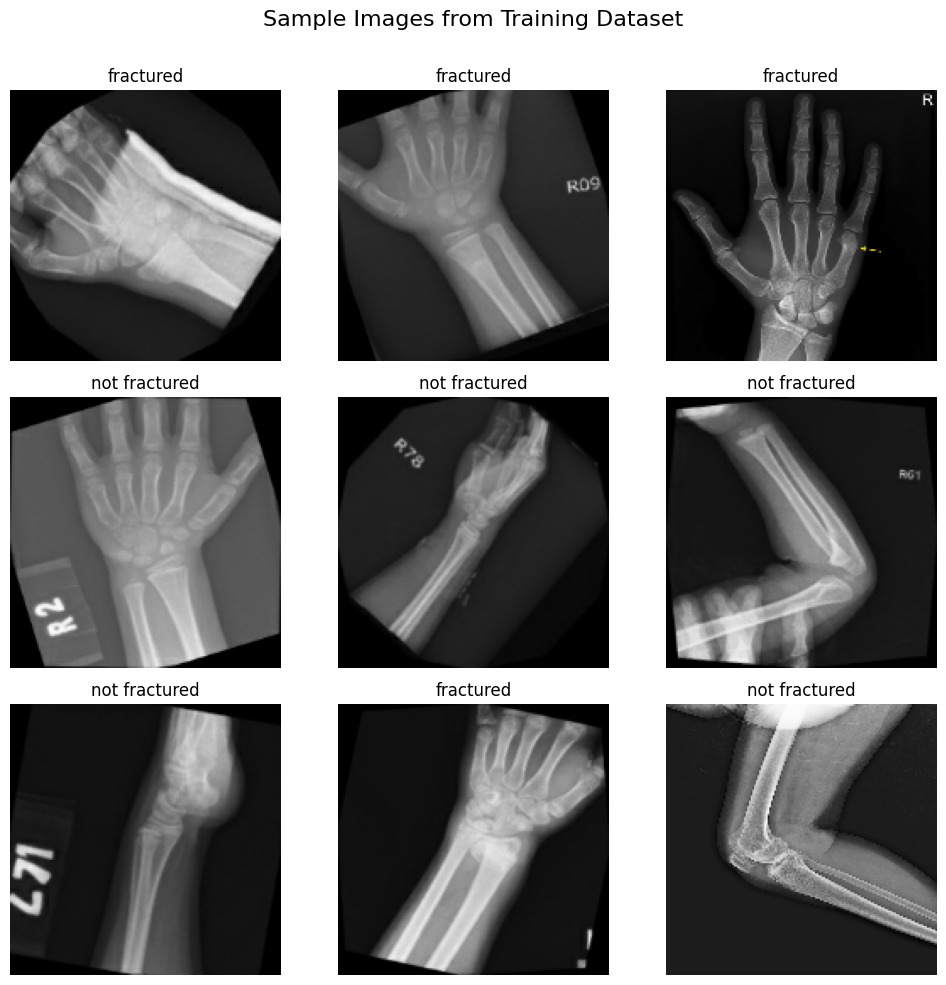

In [16]:
# sampling images from training dataset
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(2):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.suptitle("Sample Images from Training Dataset", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

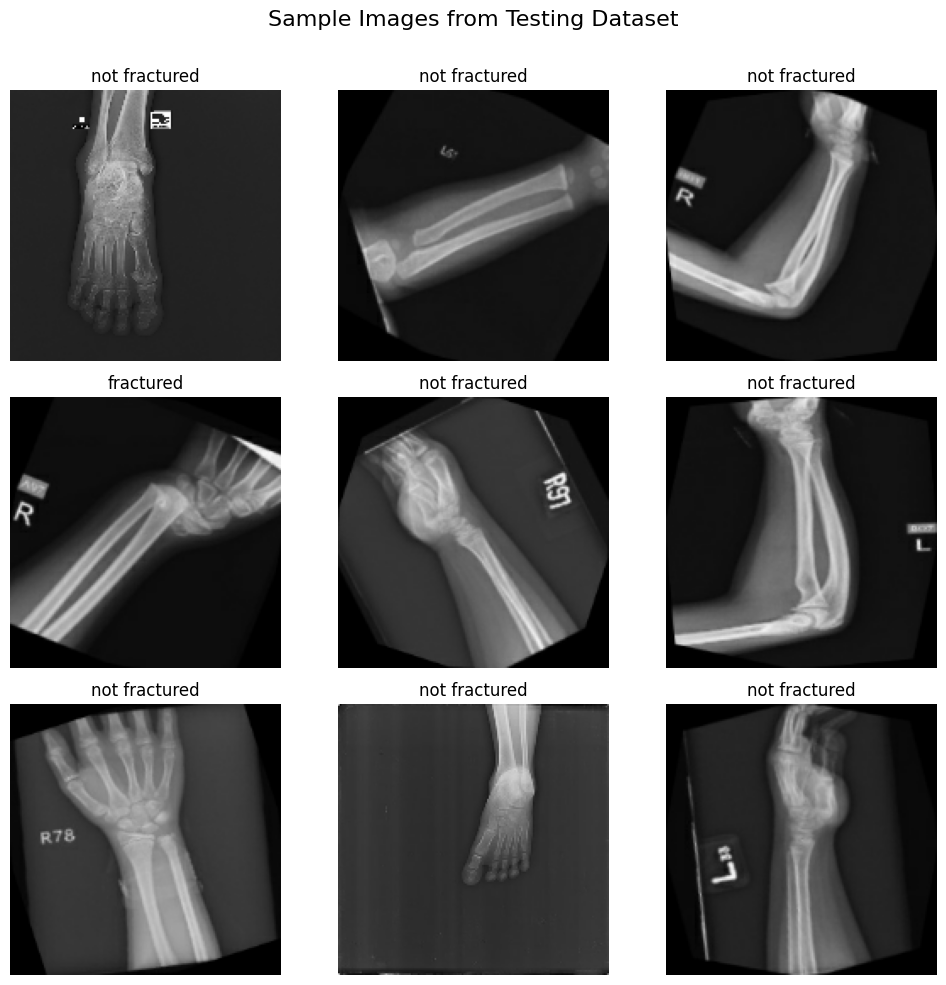

In [17]:
# sampling images from testing dataset
plt.figure(figsize=(10, 10))
for images, labels in test_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.suptitle("Sample Images from Testing Dataset", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

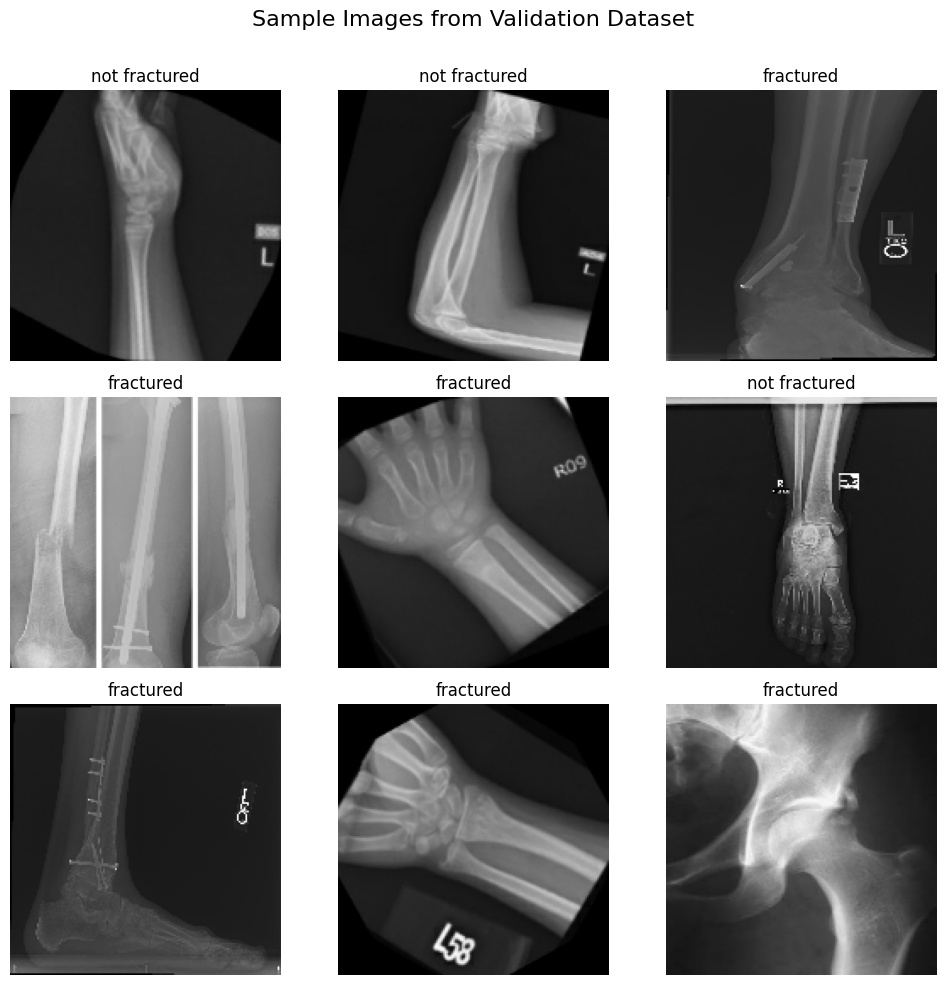

In [18]:
# sampling images from validation dataset
plt.figure(figsize=(10, 10))
for images, labels in validation_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.suptitle("Sample Images from Validation Dataset", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

In [19]:
batch_size

32

In [20]:
tf.data.AUTOTUNE

-1

In [21]:
autotune = tf.data.AUTOTUNE

In [22]:
# Optimize dataset performance with prefetching
train_dataset = train_dataset.prefetch(buffer_size=autotune)
validation_dataset = validation_dataset.prefetch(buffer_size=autotune)
test_dataset = test_dataset.prefetch(buffer_size=autotune)

In [23]:
len(train_dataset)

289

In [24]:
len(test_dataset)

16

In [25]:
len(validation_dataset)

26

In [26]:
# Data augmentation
horizontal_flips = tf.keras.layers.RandomFlip('horizontal')
radians = tf.keras.layers.RandomRotation(0.02)

In [27]:
data_augmentation = tf.keras.Sequential([
    horizontal_flips,
    radians
])

In [28]:
type(data_augmentation)

keras.src.models.sequential.Sequential

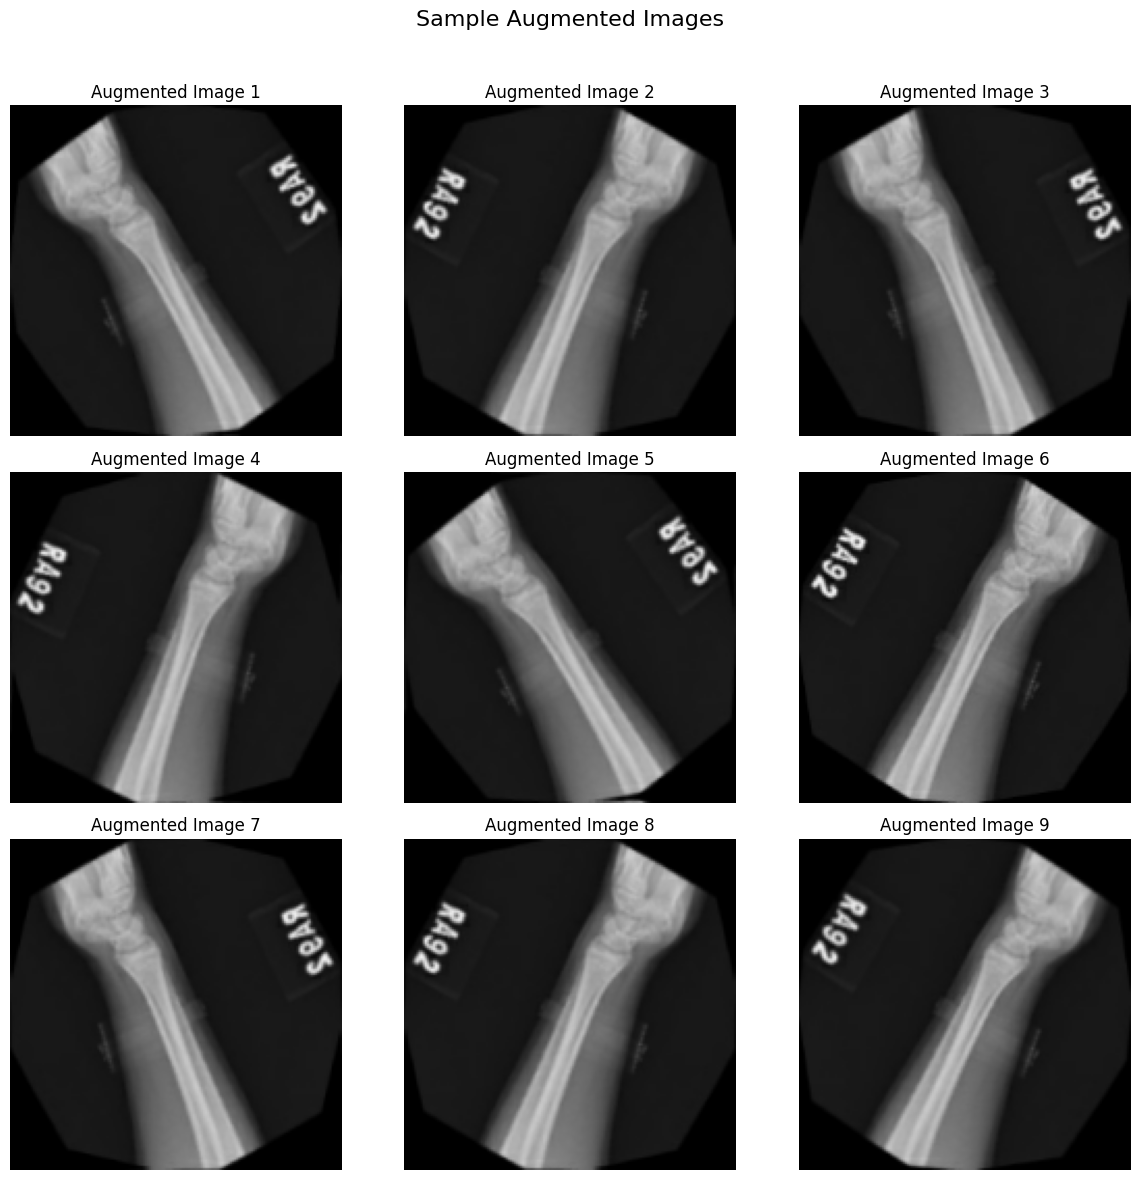

In [29]:
# Visualize augmented images
plt.figure(figsize=(12, 12))
for images, _ in train_dataset.take(1):
    sample_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(sample_image, 0))
        plt.imshow(augmented_image[0].numpy().astype("uint8"))
        plt.axis('off')
        plt.title(f"Augmented Image {i+1}", fontsize=12)
plt.suptitle("Sample Augmented Images", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

In [30]:
img_shape = img_size + (3,) # MobileNetV2 only works with RGB

In [31]:
img_size

(160, 160)

In [32]:
img_shape

(160, 160, 3)

In [33]:
base_model = tf.keras.applications.MobileNetV2(input_shape=img_shape, 
                                               include_top=False, # Exclude the ImageNet classifier at the top
                                               weights='imagenet') # Use the pre-trained weights from ImageNet

In [34]:
base_model.trainable = False # Freeze the base model to keep the pre-trained weights

In [35]:
inputs = tf.keras.Input(shape=img_shape)
x = data_augmentation(inputs)
x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
x = base_model(x, training=False)

In [36]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D() # layer object

# Apply the layer to MobileNetV2
x = global_average_layer(x)
# x = tf.keras.layers.Dropout(0.2)(x) ### Optional: Add a dropout layer

prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid') # layer object
# Apply Fully Connected Layer to predict the class
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [37]:
print("Number of neurons:", prediction_layer.units)

Number of neurons: 1


In [38]:
model.layers

[<InputLayer name=input_layer_2, built=True>,
 <Sequential name=sequential, built=True>,
 <Functional name=mobilenetv2_1.00_160, built=True>,
 <GlobalAveragePooling2D name=global_average_pooling2d, built=True>,
 <Dense name=dense, built=True>]

In [39]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [40]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.1,
    decay_steps=batch_size, # Learning rate will decrease every batch
    decay_rate=0.8 # rate of decrease means 90% of the learning rate is decreased
)

In [41]:
# Compile the model structure for training
base_learning_rate = 0.1
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), # Adam deals with gradient descent
              loss=tf.keras.losses.BinaryCrossentropy(), # measures the difference between two probability distributions
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')]) # calculates how often predictions match binary labels

In [42]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [43]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(filepath='best_model.keras', monitor='val_loss', save_best_only=True)

In [44]:
# Epochs are the number of times the model will see the entire dataset
# Start with a small number of epochs to prevent overfitting
# Epochs usually are in the range of 10 to 100. Standard is up to 50.
initial_epochs = 10

In [45]:
# start time
start = time.time()

import json

# Train the model with callbacks
history = model.fit(
    train_dataset,
    epochs=initial_epochs,
    validation_data=validation_dataset,
    callbacks=[early_stopping, model_checkpoint], # Callbacks are used to customize the training process
    verbose=2  # Verbosity level: 1 = progress bar, 2 = one line per epoch
)

# Save training history
with open('training_history.json', 'w') as file: # open creates a file
    json.dump(history.history, file) # dump saves it as a json file

# end time
end = time.time()
print(f"Elapsed time: {end - start:.4f} seconds")

Epoch 1/10
289/289 - 31s - 108ms/step - accuracy: 0.9048 - loss: 0.4733 - val_accuracy: 0.9465 - val_loss: 0.2589
Epoch 2/10
289/289 - 26s - 91ms/step - accuracy: 0.9731 - loss: 0.0871 - val_accuracy: 0.9502 - val_loss: 0.2491
Epoch 3/10
289/289 - 26s - 89ms/step - accuracy: 0.9795 - loss: 0.0603 - val_accuracy: 0.9502 - val_loss: 0.2406
Epoch 4/10
289/289 - 25s - 87ms/step - accuracy: 0.9789 - loss: 0.0607 - val_accuracy: 0.9502 - val_loss: 0.2449
Epoch 5/10
289/289 - 25s - 86ms/step - accuracy: 0.9797 - loss: 0.0602 - val_accuracy: 0.9490 - val_loss: 0.2445
Epoch 6/10
289/289 - 25s - 86ms/step - accuracy: 0.9820 - loss: 0.0572 - val_accuracy: 0.9490 - val_loss: 0.2445
Epoch 7/10
289/289 - 26s - 88ms/step - accuracy: 0.9792 - loss: 0.0620 - val_accuracy: 0.9490 - val_loss: 0.2445
Epoch 8/10
289/289 - 26s - 89ms/step - accuracy: 0.9794 - loss: 0.0629 - val_accuracy: 0.9490 - val_loss: 0.2445
Epoch 9/10
289/289 - 26s - 89ms/step - accuracy: 0.9803 - loss: 0.0588 - val_accuracy: 0.9490 -

In [47]:
# Using the best of the basic models
model_basic = tf.keras.models.load_model('best_model.keras')

In [48]:
# Evaluate the basic model on the test dataset
test_loss_basic, test_accuracy_basic = model_basic.evaluate(test_dataset)

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 0.9152 - loss: 0.3416


In [49]:
# Load training history
with open('training_history.json', 'r') as file:
    training_history = json.load(file)

In [50]:
training_history["accuracy"]

[0.9047619104385376,
 0.9730519652366638,
 0.9795454740524292,
 0.9788960814476013,
 0.9796536564826965,
 0.9820346236228943,
 0.9792208075523376,
 0.9794372320175171,
 0.9803030490875244,
 0.980627715587616]

In [51]:
training_history["val_accuracy"]

[0.9465370774269104,
 0.9501822590827942,
 0.9501822590827942,
 0.9501822590827942,
 0.9489672183990479,
 0.9489672183990479,
 0.9489672183990479,
 0.9489672183990479,
 0.9489672183990479,
 0.9489672183990479]

In [52]:
training_history["loss"]

[0.47325435280799866,
 0.08705100417137146,
 0.06027258187532425,
 0.06066043674945831,
 0.06018020212650299,
 0.057233572006225586,
 0.06200912967324257,
 0.06285306811332703,
 0.05883805453777313,
 0.06576220691204071]

In [53]:
training_history["val_loss"]

[0.2588716745376587,
 0.24905161559581757,
 0.2405596524477005,
 0.2449294775724411,
 0.2444930076599121,
 0.2444852888584137,
 0.24449357390403748,
 0.24449507892131805,
 0.2444949746131897,
 0.2444949448108673]

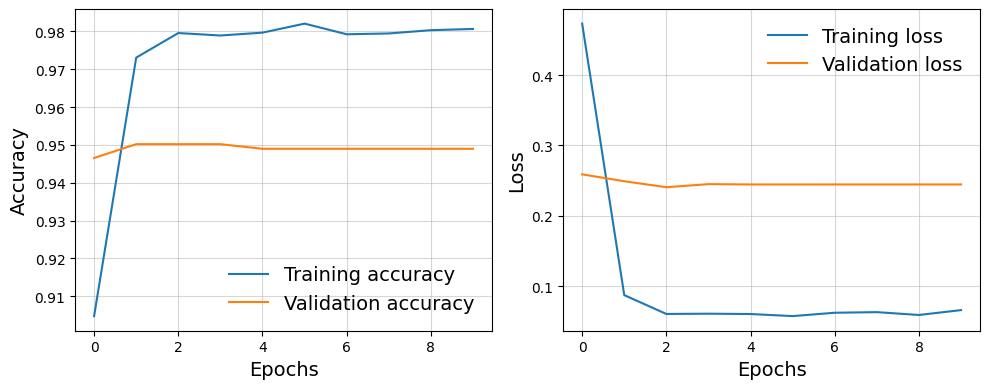

In [56]:
# plot the data
#settings
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
epochs = np.arange(len(training_history["accuracy"]))
fs = 14
fs_ticks = 10
# training and validation accuracy
ax[0].plot(epochs, training_history["accuracy"], label="Training accuracy")
ax[0].plot(epochs, training_history["val_accuracy"], label="Validation accuracy")
ax[0].set_ylabel("Accuracy", fontsize=fs)
ax[0].grid(True, alpha=0.5)
ax[0].set_xlabel("Epochs", fontsize=fs)
ax[0].legend(frameon=False, fontsize=fs)

# trainng and validation loss
ax[1].plot(epochs, training_history["loss"], label="Training loss")
ax[1].plot(epochs, training_history["val_loss"], label="Validation loss")
ax[1].set_ylabel("Loss", fontsize=fs)
ax[1].grid(True, alpha=0.5)
ax[1].set_xlabel("Epochs", fontsize=fs)
ax[1].legend(frameon=False, fontsize=fs)

plt.tight_layout()
plt.savefig("plot/accuracy_loss_basic.png", dpi=600, bbox_inches="tight")
plt.show()

In [58]:
type(test_dataset)

tensorflow.python.data.ops.prefetch_op._PrefetchDataset

In [59]:
y_true_basic = []
y_pred_basic = []

for X_batch_basic, labels in test_dataset:
    preds = model_basic.predict(X_batch_basic).flatten()
    bin_preds = (preds > 0.5).astype("int32")
    y_true_basic.extend(labels.numpy())
    y_pred_basic.extend(bin_preds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 705ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 687ms/step


In [60]:
y_true_basic

[0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,


In [61]:
y_pred_basic

[0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,


In [62]:
#ground_truth is your y_true
#prediction is your y_pred
ground_truth_basic = y_true_basic
predictions_basic = y_pred_basic

In [63]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [64]:
class_names

['fractured', 'not fractured']

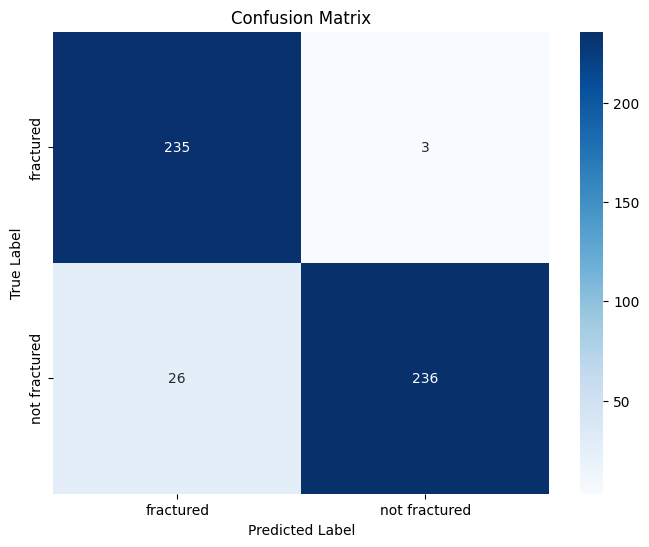

In [67]:
# Compute confusion a
conf_matrix = confusion_matrix(ground_truth_basic, predictions_basic)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.savefig("plot/cm_basic.png", dpi=600, bbox_inches="tight")
plt.show()

In [68]:
from sklearn.metrics import classification_report

In [69]:
# Print classification report
print("Classification Report:")
print(classification_report(ground_truth_basic, predictions_basic, target_names=class_names))


Classification Report:
               precision    recall  f1-score   support

    fractured       0.90      0.99      0.94       238
not fractured       0.99      0.90      0.94       262

     accuracy                           0.94       500
    macro avg       0.94      0.94      0.94       500
 weighted avg       0.95      0.94      0.94       500



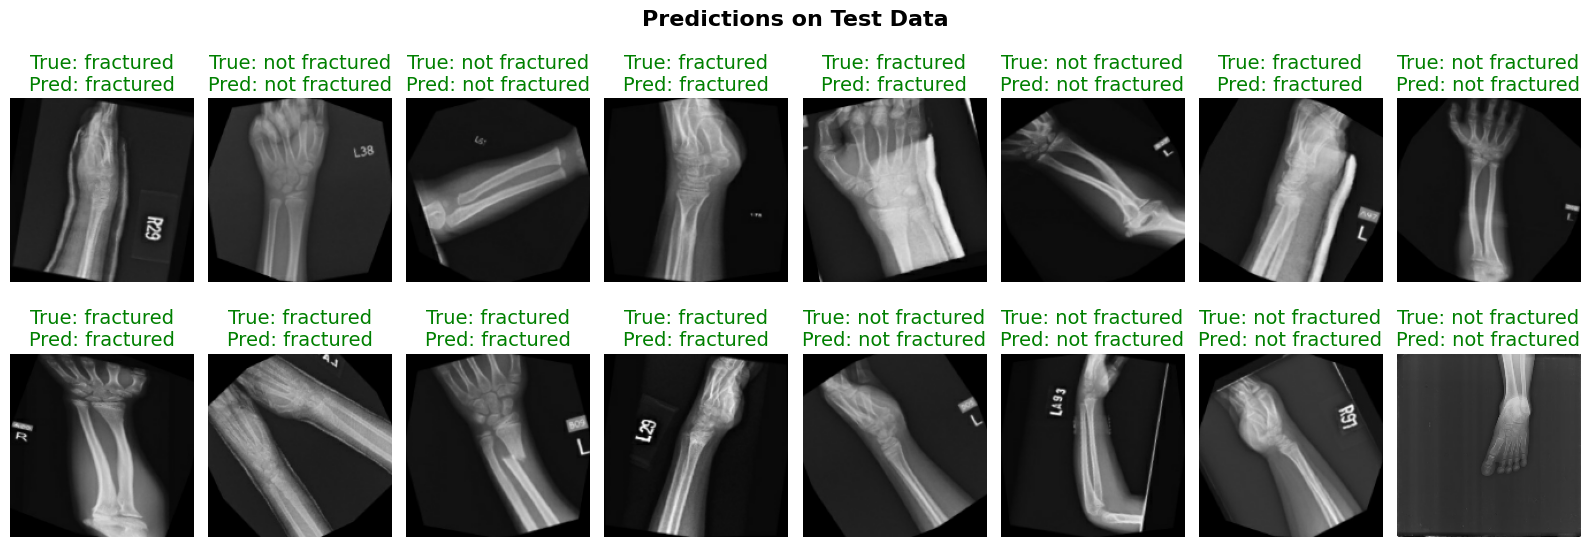

In [71]:
# Get a batch of test data
image_batch, label_batch = test_dataset.as_numpy_iterator().next()

# Generate predictions
predictions_basic = model_basic.predict_on_batch(image_batch).flatten()
predictions_basic = tf.where(predictions_basic < 0.5, 0, 1).numpy()  # Apply threshold for binary classification

# Visualize predictions
plt.figure(figsize=(16, 6))
for i in range(16):  # Increase the number of images to 16
    ax = plt.subplot(2, 8, i + 1)  # Adjust the grid to 4x4
    plt.imshow(image_batch[i].astype("uint8"))
    true_label = label_batch[i]
    pred_label = predictions_basic[i]
    title = f"True: {class_names[true_label]}\nPred: {class_names[pred_label]}"
    color = 'green' if true_label == pred_label else 'red'
    plt.title(title, color=color, fontsize=14)  # Make the font size smaller
    plt.axis("off")
plt.suptitle("Predictions on Test Data", fontsize=16, fontweight='bold')
plt.tight_layout()
#plt.subplots_adjust(top=0.92)
plt.savefig("plot/predictions_basic_2.png", dpi=600, bbox_inches="tight")
plt.show()